# EDA of go_annotations.csv

In [40]:
import pandas as pd

# Load the GO annotations CSV
df = pd.read_csv('/home/ncorley/protein/ProteinFunctions/data/go_annotations.csv')
df.head()

,go_id,description,annotation_class_label,comment,synonym
0,GO:1904924,"Any process that stops, prevents or reduces th...",negative regulation of mitophagy in response t...,NaN,down regulation of mitophagy in response to mi...
1,GO:1904923,"Any process that modulates the frequency, rate...",regulation of autophagy of mitochondrion in re...,NaN,NaN
2,GO:1904928,Any coreceptor activity that is involved in a ...,coreceptor activity involved in canonical Wnt ...,NaN,"Wnt co-receptor activity, canonical signaling|..."
3,GO:1904927,Any process that results in a change in state ...,cellular response to palmitoleic acid,NaN,NaN
4,GO:1904926,Any process that results in a change in state ...,response to palmitoleic acid,NaN,NaN


In [52]:
# Count unique go_id and compare to GO vocabulatry
print("Number unique go_id in csv:", df['go_id'].nunique())

# Load vocab and count unique go_id
import json
import random
with open('/home/ncorley/protein/ProteinFunctions/data/vocabularies/GO_label_vocab.json') as f:
    vocab = json.load(f)
print("Number unique go_id in vocabulary:", len(vocab))

# Check how many go_id are in the csv but not in the vocabulary
csv_go_ids = set(df['go_id'].unique())
vocab_go_ids = set(vocab)
print("Number of go_id in csv but not in vocabulary:", len(csv_go_ids - vocab_go_ids))

# Check how many go_id are in the vocabulary but not csv
print("Number of go_id in vocabulary but not in csv:", len(vocab_go_ids - csv_go_ids))

# Get the set difference between the vocabulary and the CSV
missing_go_ids = vocab_go_ids - csv_go_ids

# Convert the set to a list
missing_go_ids_list = list(missing_go_ids)

# Print a random sample of the missing GO IDs
print("Random sample of GO IDs in vocabulary but not in CSV:")
print(random.sample(missing_go_ids_list, k=10))

# Note: From random sample of 10 go_id in the vocabulary but not in the csv, all were obsolete or had been remapped to a different go_id

Number unique go_id in csv: 42950
Number unique go_id in vocabulary: 32102
Number of go_id in csv but not in vocabulary: 12674
Number of go_id in vocabulary but not in csv: 1826
Random sample of GO IDs in vocabulary but not in CSV:
['GO:0034207', 'GO:0034437', 'GO:0000186', 'GO:0031497', 'GO:0048310', 'GO:0097659', 'GO:0043006', 'GO:0072321', 'GO:2000578', 'GO:0017144']


# EDA of PubMedBERt

In [18]:
import torch

if torch.cuda.is_available():
    print('CUDA is available!')
    print('CUDA version:', torch.version.cuda)
else:
    print('CUDA is not available.')

CUDA is available!
CUDA version: 11.7


In [31]:
from transformers import BertTokenizer, BertModel
import torch

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
model = BertModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

/anaconda/envs/protein_functions/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# Sample text
text = "This is a sample abstract about biomedical research."

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Tokenize the text and obtain the output tensors
inputs = tokenizer(text, return_tensors="pt")

# Move the tensors to GPU if available
inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
model = model.to(device)

# Get the embeddings
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state

In [21]:
# Get the shape of the embeddings and outputs
print("Outputs shape:", outputs.pooler_output.shape)
print("Embeddings shape:", embeddings.shape)

# Get the [CLS] token embedding
sequence_embedding = embeddings[0][0]

Outputs shape: torch.Size([1, 768])
Embeddings shape: torch.Size([1, 11, 768])


# EDA of label_embeddings.pk1

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataframe from the pickle file
go_annotations_df = pd.read_pickle("/home/ncorley/protein/ProteinFunctions/data/swissprot/proteinfer_splits/random/label_embeddings.pk1")

# Display the first few rows of the dataframe
display(go_annotations_df.head())

,go_id,description,annotation_class_label,comment,synonym,out_degree,embedding
0,GO:1904924,"Any process that stops, prevents or reduces th...",negative regulation of mitophagy in response t...,NaN,down regulation of mitophagy in response to mi...,2,"[-0.19203259, 0.0036893275, 0.46602038, -0.332..."
1,GO:1904923,"Any process that modulates the frequency, rate...",regulation of autophagy of mitochondrion in re...,NaN,NaN,2,"[0.013970085, -0.065674566, 0.4478878, -0.3971..."
2,GO:1904928,Any coreceptor activity that is involved in a ...,coreceptor activity involved in canonical Wnt ...,NaN,"Wnt co-receptor activity, canonical signaling|...",<NA>,"[-0.1843568, -0.038391832, 0.30839404, -0.1521..."
3,GO:1904927,Any process that results in a change in state ...,cellular response to palmitoleic acid,NaN,NaN,2,"[0.08549239, -0.07233671, 0.086257726, -0.0960..."
4,GO:1904926,Any process that results in a change in state ...,response to palmitoleic acid,NaN,NaN,1,"[0.15115559, 0.062270537, 0.058555294, 0.00039..."


In [23]:
# 1. Basic Statistics
print("1. Basic Statistics")
print("-------------------")
num_entries = len(go_annotations_df)
num_unique_go_ids = go_annotations_df['go_id'].nunique()
missing_values = go_annotations_df.isnull().sum()

print(f"Total number of entries: {num_entries}")
print(f"Number of unique GO IDs: {num_unique_go_ids}")
print(f"Missing values in each column:\n{missing_values}")

1. Basic Statistics
-------------------
Total number of entries: 42950
Number of unique GO IDs: 42950
Missing values in each column:
go_id                         0
description                   0
annotation_class_label        0
comment                   40568
synonym                   14960
out_degree                  101
embedding                     0
dtype: int64


In [24]:
# 2. Embedding Analysis
print("\n2. Embedding Analysis")
print("----------------------")

# Check the dimensionality of the embeddings
embedding_dim = len(go_annotations_df['embedding'].iloc[0])
print(f"Dimensionality of the embeddings: {embedding_dim}")

# Check if embeddings for the same go_id are consistent
inconsistent_go_ids = []
for go_id, group in go_annotations_df.groupby('go_id'):
    unique_embeddings = group['embedding'].apply(tuple).nunique()
    if unique_embeddings > 1:
        inconsistent_go_ids.append(go_id)

if inconsistent_go_ids:
    print(f"Number of GO IDs with inconsistent embeddings: {len(inconsistent_go_ids)}")
else:
    print("All GO IDs have consistent embeddings.")

# Compute average cosine similarity between embeddings
embeddings_matrix = np.stack(go_annotations_df['embedding'].to_numpy())
similarity_matrix = cosine_similarity(embeddings_matrix)
avg_similarity = np.mean(similarity_matrix)

print(f"Average cosine similarity between embeddings: {avg_similarity:.4f}")


2. Embedding Analysis
----------------------
Dimensionality of the embeddings: 768
All GO IDs have consistent embeddings.
Average cosine similarity between embeddings: 0.8856



3. Out Degree Analysis
----------------------


/anaconda/envs/protein_functions/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/anaconda/envs/protein_functions/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/anaconda/envs/protein_functions/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


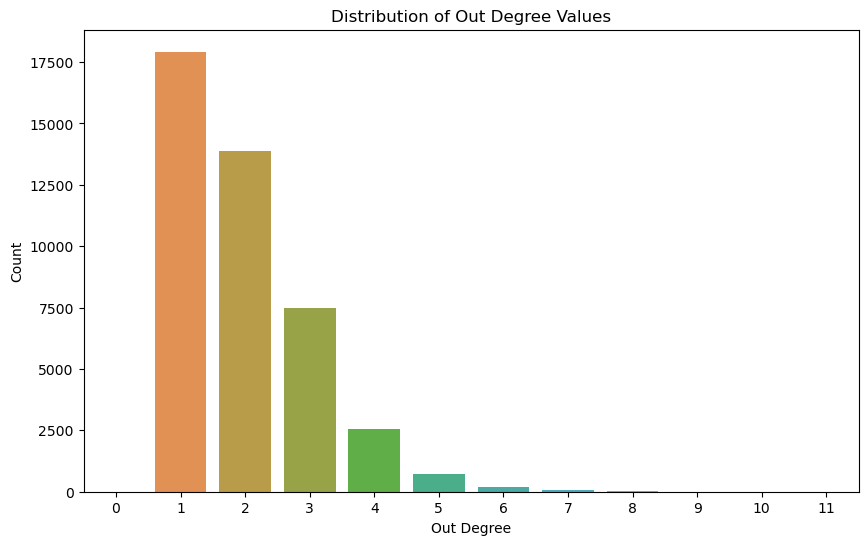

Counts of each Out Degree value:
out_degree
1     17921
2     13884
3      7469
4      2570
5       738
6       193
7        56
8        10
9         3
0         3
10        1
11        1
Name: count, dtype: Int64


<Figure size 1000x600 with 0 Axes>

In [25]:
# 3. Out Degree Analysis
print("\n3. Out Degree Analysis")
print("----------------------")

# Drop rows with missing out_degree values
go_annotations_df_clean = go_annotations_df.dropna(subset=['out_degree'])

# Visualize the distribution of out_degree values
plt.figure(figsize=(10, 6))
sns.countplot(data=go_annotations_df_clean, x='out_degree')
plt.title("Distribution of Out Degree Values")
plt.xlabel("Out Degree")
plt.ylabel("Count")
plt.show()

# Print the histogram of out_degree values
plt.figure(figsize=(10, 6))

# Get and print the counts of each unique out_degree value
out_degree_counts = go_annotations_df_clean['out_degree'].value_counts()
print("Counts of each Out Degree value:")
print(out_degree_counts)

# Testing the Dataset and Dataloader

In [54]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))

%load_ext autoreload
%autoreload 2

from src.data.datasets import ProteinDataset
from torch.utils.data import DataLoader
from src.data.collators import collate_variable_sequence_length

# Define the base directory for the project
BASE_DIR = '/home/ncorley/protein/ProteinFunctions/'

# Define the relative paths to the data and vocabulary files
TRAIN_DATA_PATH = os.path.join(BASE_DIR, 'data', 'swissprot', 'proteinfer_splits', 'random', 'train_GO.fasta')
VAL_DATA_PATH = os.path.join(BASE_DIR, 'data', 'swissprot', 'proteinfer_splits', 'random', 'dev_GO.fasta')
TEST_DATA_PATH = os.path.join(BASE_DIR, 'data', 'swissprot', 'proteinfer_splits', 'random', 'train_GO.fasta')
AMINO_ACID_VOCAB_PATH = os.path.join(BASE_DIR, 'data', 'vocabularies', 'amino_acid_vocab.json')
GO_LABEL_VOCAB_PATH = os.path.join(BASE_DIR, 'data', 'vocabularies', 'GO_label_vocab.json')

# Parameters
TEST_BATCH_SIZE = 8

# Create a single ProteinDataset object
test_dataset = ProteinDataset(data_path=TEST_DATA_PATH,
                             sequence_vocabulary_path=AMINO_ACID_VOCAB_PATH,
                             label_vocabulary_path=GO_LABEL_VOCAB_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing vocabularies... Done.
Loading sequence embeddings and converting to dict...
Loaded sequence embeddings.
Loading label embeddings and converting to dict...
Loaded label embeddings.


In [55]:
## Print all class variables and their types
print("Class variables: \n")
for key, value in test_dataset.__dict__.items():
    print(f"{key}: {type(value)}")

Class variables: 

data_path: <class 'str'>
sequence_vocabulary_path: <class 'str'>
label_vocabulary_path: <class 'str'>
max_seq_len: <class 'NoneType'>
sequence_embedding_path: <class 'str'>
label_embedding_path: <class 'str'>
data: <class 'list'>
sequence_vocabulary: <class 'list'>
sequence_vocabulary_size: <class 'int'>
aminoacid2int: <class 'dict'>
int2aminoacid: <class 'dict'>
label_vocabulary: <class 'list'>
label_vocabulary_size: <class 'int'>
label2int: <class 'dict'>
int2label: <class 'dict'>
sequence_embeddings: <class 'dict'>
label_embeddings: <class 'dict'>


In [70]:
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1,
                          collate_fn=collate_variable_sequence_length)

In [72]:
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_variable_sequence_length)
sequence_onehots, labels_multihot, sequence_length, sequence_embedding, label_embeddings = next(iter(test_loader))


Getting item...
Sequence: MSKIIEYDETARRAIEAGVNTLADAVRVTLGPRGRHVVLAKAFGGPAVTNDGVTVAREIDLEDPFENLGAQLVKSVATKTNDVAGDGTTTATVLAQALVKGGLRLVAAGANPIELGAGISKAADAVSEALLASATPVSGKDAIAQVATVSSRDQVLGELVGEAMTKVGVDGVVSVEESSTLNTELEFTEGVGFDKGFLSAYFVTDFDAQQAVLDDPVILLHQEKISSLPDLLPMLEKVAESGKPLLIIAEDIEGEALATLVVNSIRKTLKAVAVKAPFFGDRRKAFLEDLAIVTGGQVINPDTGLLLREVGTEVLGSARRVVVSKDDTIIVDGGGAKDAVANRIKQLRAEIEKTDSDWDREKLQERLAKLAGGVAVIKVGAATETALKERKESVEDAVAAAKAAVEEGIVAGGGSALLQARKALDELRGSLSGDQALGVDVFAEALGAPLYWIASNAGLDGAVAVHKVAELPAGHGLNAEKLSYGDLIADGVIDPVKVTRSAVLNSASVARMVLTTETAVVDKPAEEADDHGHGHHHH
Labels: ['GO:0036094', 'GO:0032559', 'GO:0030554', 'GO:0032553', 'GO:0005488', 'GO:0042026', 'GO:0097367', 'GO:0051082', 'GO:0097159', 'GO:0043167', 'GO:0032555', 'GO:0006457', 'GO:0009987', 'GO:0003674', 'GO:0005737', 'GO:0005575', 'GO:0005524', 'GO:0035639', 'GO:0008150', 'GO:0017076', 'GO:0005515', 'GO:0000166', 'GO:0043168', 'GO:1901363', 'GO:1901265']
Labels not in label2int dictionary BEFORE: set()
Labels not in label2int dic

RuntimeError: stack expects each tensor to be equal size, but got [20, 538] at entry 0 and [20, 792] at entry 1

In [ ]:
# Print the first few entries of label_embeddings
print("\nFirst few entries of label_embeddings:")
print(test_dataset.label_embeddings[:5])

# Print first few entries of the data
print("\nFirst few entries of the data:")
print(test_dataset.data[:5])


First few entries of label_embeddings:


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Test Label Embedding Lookup
def test_label_embedding_lookup(dataset):
    labels = ["sample_label1", "sample_label2"]  # Replace with some sample labels from your data
    embeddings = dataset._lookup_label_embeddings(labels)
    assert embeddings is not None, "Label embedding lookup failed!"
    print("Label Embedding Lookup Test Passed!")

# Test Item Retrieval
def test_item_retrieval(dataset):
    item = dataset[0]
    assert item is not None, "Item retrieval failed!"
    print("Item Retrieval Test Passed!")

# EDA of ProteinInfer embeddings

In [29]:
# Import the pickle from data/swissprot/proteinfer_splits/random/combined_embeddings.pk1
import pickle
import pandas as pd

# Load the dataframe from the pickle file
sequence_embeddings_df = pd.read_pickle("/home/ncorley/protein/ProteinFunctions/data/swissprot/proteinfer_splits/random/sequence_embeddings.pk1")

# Print shape of the df
print("Shape of the dataframe:", sequence_embeddings_df.shape)
display(sequence_embeddings_df.head(10))


Shape of the dataframe: (439540, 2)


,sequence,embedding
0,MANPLYQKHIISINDLSRDDLNLVLATAAKLKANPQPELLKHKVIA...,"[-0.28971588611602783, -1.4092315435409546, 0...."
1,MQRRHFLKNAAAALAALGLPALPPWALAAKAVGLRRLGQPQPFDYA...,"[-0.9862877130508423, -0.5633257627487183, 0.5..."
2,MANNSNSGSELEVDDTLQSICYNRGSLKLLDQRKLPLETEFLDIRN...,"[-0.14604131877422333, -0.083809994161129, -1...."
3,MNAFYNKEGVGDTLLISLQDVTREQLGYEKHGDVVKIFNNETKETT...,"[-0.7522125244140625, 0.3685571551322937, -0.1..."
4,MAMSDRLLAAWYHGHPALTLLRPLEWLYRRVVAGKRQRFLDGEGEI...,"[0.319398432970047, 0.6143203377723694, -0.135..."
5,MKPWAVGLGPPPPAVPLLLLLLLGAALVRAAAPPRRYTPDWQSLDS...,"[0.1517590433359146, 0.3703460693359375, -0.38..."
6,MFHVKHPQREVAATRQRAVGQWPTDPYPRRLNVWPGIRDASMLDGM...,"[-0.6309232115745544, 0.5793448686599731, -0.0..."
7,MRFAIVVTGPAYGTQQASSAFQFAQALIAEGHELSSVFFYREGVYN...,"[-0.5407073497772217, -0.9115131497383118, 0.7..."
8,MSTSQNLSQTPVKETLLTPRFYTTDFDEMSKLDISSNIDEFEALLQ...,"[-0.27093568444252014, 0.9554061889648438, 1.6..."
9,MELVEIREGLARVLVPKAERIYDAPVFYNPVMALNRDISVLAVKAL...,"[-0.13192899525165558, 0.22488205134868622, 0...."


In [30]:
# 2. Embedding Analysis
print("\n2. Embedding Analysis")
print("----------------------")

# Check the dimensionality of the embeddings
embedding_dim = len(sequence_embeddings_df['embedding'].iloc[0])
print(f"Dimensionality of the embeddings: {embedding_dim}")

# Number of GO classes
print("Number of GO classes:", go_annotations_df['go_id'].nunique())


2. Embedding Analysis
----------------------
Dimensionality of the embeddings: 1100


NameError: name 'go_annotations_df' is not defined